In [1]:
#    ============================================================================================================================

#    Run this file after nestcrossvalid10_600: first test across the full range of components. Then, use this script to identify
#    the threshold (mean of the best value minus one standard deviation) to identify the new, reduced range of component values

#    ============================================================================================================================


# import data
import numpy as np
import json

# Change .json filename to select animal ID number
IDnumber = 3402
loadstring = "data/pyData/{}/{}_Data_S_Notch14_1.json"

# import standard experiment data (XS) and metadata (S_labels)
with open(loadstring.format(IDnumber, IDnumber)) as f:
    data = json.load(f)
pxx = np.array(data[0])
pxx = np.log(pxx)
a, b, c = pxx.shape
XS = pxx.reshape(a*b, c).T
S_labels = data[1]

# Train data ONLY on standard experiments from day 1: X, S_labels where subject contains 1
# stimON = 1 vs nonstim = 0 (baseline AND stimOFF)

days = np.zeros(len(S_labels['allWindows']['subject']))
for k in range(0, len(S_labels['allWindows']['subject'])):
    days[k] = int(S_labels['allWindows']['subject'][k][6])-1

numDay = int(np.ceil(max(days)))+1
duration = 539
    
X_arr = np.zeros((numDay, duration), dtype = int)
Y_arr = np.zeros((numDay, duration), dtype = int)
    
for k in range(0, len(S_labels['allWindows']['subject'])):
    d = int(S_labels['allWindows']['subject'][k][6])-1
    w = S_labels['allWindows']['windowID'][k]-1
    if w < duration: 
        X_arr[d, w] = k
        Y_arr[d, w] = S_labels['allWindows']['stimOn'][k]

X_list = X_arr.reshape(numDay*duration, 1)
Y_list = Y_arr.reshape(numDay*duration, 1)

X_all = XS
Y_all = np.array(S_labels['allWindows']['stimOn'])

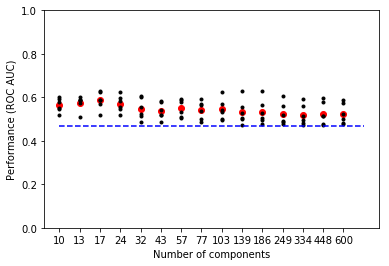

In [2]:
string0 = "data/pyData/10_600/{}_7x1x1Components.txt"
ComponentRanges = np.loadtxt(string0.format(IDnumber), delimiter = '\t')
string1 = "data/pyData/10_600/{}_nestedROC_AUC.txt"
roc_auc = np.loadtxt(string1.format(IDnumber), delimiter='\t')
roc_auc = roc_auc.reshape(numDay, (numDay-1), roc_auc.shape[1])

adjROC = np.ones((numDay, len(ComponentRanges)))
goodC = np.zeros((numDay))
for d in range(numDay): 
    bestC = np.argmax(np.mean(roc_auc[d, :, :], axis = 0))
    stan = np.std(roc_auc[d, :, bestC])
    thrsh = np.mean(roc_auc[d, :, bestC]) - stan
    for c in range(len(ComponentRanges)):
        if np.mean(roc_auc[d, :, c]) >= thrsh: adjROC[d, c] = np.mean(roc_auc[d, :, c])
        else: adjROC[d, c] = 1
            
    goodC[d] = np.argwhere(adjROC[d]<1)[0]
    
if np.all(np.mean(np.mean(roc_auc[:, :, :], axis = 0), axis = 0) > thrsh):
    upperlimit = 100
else:
    upperlimit = int(ComponentRanges[int(np.ceil(np.mean(goodC)))])

import matplotlib.pyplot as plt
s1 = plt.figure()
plt.plot(range(0, len(ComponentRanges)), np.mean(np.mean(roc_auc[:, :, :], axis = 0), axis = 0), 'ro')
for d in range(numDay):
    plt.plot(range(0, len(ComponentRanges)), np.mean(roc_auc[d, :, :], axis = 0), 'k.')
plt.ylim([0, 1])
plt.plot([0, len(ComponentRanges)], [thrsh, thrsh], 'b--')
comp = [int(0)]*len(ComponentRanges)
for i in range(0, len(ComponentRanges)): comp[i] = int(ComponentRanges[i])

plt.xticks(range(0, len(ComponentRanges)), comp)
plt.xlabel("Number of components")
plt.ylabel("Performance (ROC AUC)")
plt.show()

s = "data/pyData/GraphOutput/{}_ComponentSelection"
s1.savefig(s.format(IDnumber))

In [3]:
from sklearn.decomposition import FastICA
from sklearn import svm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc

components = np.logspace(1, np.log10(upperlimit), 15, dtype = int)

roc_auc = np.zeros((numDay, (numDay-1), len(components)))
best = np.zeros((numDay, 2))
#testID = np.arange(0, Y_all.shape[0], dtype = 'int')

outer_cv = KFold(n_splits = numDay, shuffle = True)
inner_cv = KFold(n_splits = (numDay-1), shuffle = True)

print(components)

#    inner_cv = KFold(n_splits = 8)
for subtrain, test in outer_cv.split(range(0, numDay)):
    v = 0
    for train, validate in inner_cv.split(subtrain):
        c = 0
        X_inner_trainingset = X_all[X_arr[subtrain[train], ].reshape((numDay-2)*duration), ]
        Y_inner_trainingset = Y_arr[subtrain[train], ].reshape((numDay-2)*duration)
        X_validate = X_all[X_arr[subtrain[validate], ], ].reshape(duration, 600)
        Y_validate = Y_all[X_arr[subtrain[validate]]].reshape(duration)

        for C in components:   
            print(test, subtrain[validate], subtrain[train], C)
            
            ica = FastICA(n_components = C, max_iter = 5000,tol = 0.0001) #tol = 0.001
            X_inner_train = ica.fit_transform(X_inner_trainingset) #pull components from ica fit transformation
            X_inner_test = ica.transform(X_validate)
            
            clf = svm.SVC(kernel = 'linear', class_weight = 'balanced', probability = True)
            y_inner_score = clf.fit(X_inner_train, Y_inner_trainingset).decision_function(X_inner_test)
            fpr, tpr, _ = roc_curve(Y_validate, y_inner_score)
            roc_auc[int(test), int(validate), c] = auc(fpr, tpr)

            c += 1
    
    best[int(test), 0] = int(np.argmax(np.mean(roc_auc[int(test), :, :], axis = 0)))
    print('Best components | %0.0f' % (components[int(best[int(test), 0])]))
    
    X_outer_trainingset = X_all[X_arr[subtrain, ].reshape((numDay-1)*duration), ]
    Y_outer_trainingset = Y_arr[subtrain, ].reshape((numDay-1)*duration)
    X_test = X_all[X_arr[test, ], ].reshape(duration, 600)
    Y_test = Y_all[X_arr[test]].reshape(duration)
    
    
    ica = FastICA(n_components = components[int(best[int(test), 0])], max_iter = 5000,tol = 0.0001) #tol = 0.001
    X_outer_train = ica.fit_transform(X_outer_trainingset) #pull components from ica fit transformation
    X_outer_test = ica.transform(X_test)
    
    clf = svm.SVC(kernel = 'linear', class_weight = 'balanced', probability = True)
    y_outer_score = clf.fit(X_outer_train, Y_outer_trainingset).decision_function(X_outer_test)
    fpr, tpr, _ = roc_curve(Y_test, y_outer_score)
    best[int(test), 1] = auc(fpr, tpr)
    print('8x1 ROC AUC | %0.2f' % (best[int(test), 1]*100))
    
for i in range(0, numDay): best[i, 0] = components[int(best[i, 0])]

string0 = "data/pyData/{}/{}_7x1x1Components.txt"
np.savetxt(string0.format(IDnumber, IDnumber), components, delimiter='\t')
string1 = "data/pyData/{}/{}_nestedROC_AUC.txt"
np.savetxt(string1.format(IDnumber, IDnumber), roc_auc.reshape(numDay*(numDay-1),len(components)), delimiter='\t')
string2 = "data/pyData/{}/{}_nestedTestROC_AUC.txt"
np.savetxt(string2.format(IDnumber, IDnumber), best, delimiter='\t')

[ 10  11  13  16  19  22  26  31  37  43  51  61  71  84 100]
[1] [3] [0 2 4 5] 10
[1] [3] [0 2 4 5] 11
[1] [3] [0 2 4 5] 13
[1] [3] [0 2 4 5] 16


C:\Users\Bradley Barth\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


[1] [3] [0 2 4 5] 19
[1] [3] [0 2 4 5] 22
[1] [3] [0 2 4 5] 26
[1] [3] [0 2 4 5] 31
[1] [3] [0 2 4 5] 37
[1] [3] [0 2 4 5] 43
[1] [3] [0 2 4 5] 51
[1] [3] [0 2 4 5] 61
[1] [3] [0 2 4 5] 71
[1] [3] [0 2 4 5] 84
[1] [3] [0 2 4 5] 100
[1] [5] [0 2 3 4] 10
[1] [5] [0 2 3 4] 11
[1] [5] [0 2 3 4] 13
[1] [5] [0 2 3 4] 16
[1] [5] [0 2 3 4] 19
[1] [5] [0 2 3 4] 22
[1] [5] [0 2 3 4] 26
[1] [5] [0 2 3 4] 31
[1] [5] [0 2 3 4] 37
[1] [5] [0 2 3 4] 43
[1] [5] [0 2 3 4] 51
[1] [5] [0 2 3 4] 61
[1] [5] [0 2 3 4] 71
[1] [5] [0 2 3 4] 84
[1] [5] [0 2 3 4] 100
[1] [2] [0 3 4 5] 10
[1] [2] [0 3 4 5] 11
[1] [2] [0 3 4 5] 13
[1] [2] [0 3 4 5] 16
[1] [2] [0 3 4 5] 19
[1] [2] [0 3 4 5] 22
[1] [2] [0 3 4 5] 26
[1] [2] [0 3 4 5] 31
[1] [2] [0 3 4 5] 37
[1] [2] [0 3 4 5] 43
[1] [2] [0 3 4 5] 51
[1] [2] [0 3 4 5] 61
[1] [2] [0 3 4 5] 71
[1] [2] [0 3 4 5] 84
[1] [2] [0 3 4 5] 100
[1] [4] [0 2 3 5] 10
[1] [4] [0 2 3 5] 11
[1] [4] [0 2 3 5] 13
[1] [4] [0 2 3 5] 16
[1] [4] [0 2 3 5] 19
[1] [4] [0 2 3 5] 22
[1] [4] [0

In [4]:
C = components[np.argsort(np.mean(np.mean(roc_auc, axis = 0), axis = 0))[-1]]

print('Best components | %0.0f \n' % (C))

from sklearn.decomposition import FastICA
from sklearn import svm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc

cv = KFold(n_splits = numDay, shuffle = True)
roc8x1 = [0] * numDay
fpr = [0] * numDay
tpr = [0] * numDay
y_scoreTest = [0] * numDay
y_scoreTestArray = np.zeros((numDay, duration))
y_scoreTrain = [0] * numDay
y_scoreTrainArray = np.zeros((numDay, (numDay-1)*duration))

for train, test in cv.split(range(0, numDay)):  
    X_trainingset = X_all[X_arr[train, ].reshape((numDay-1)*duration), ]
    Y_trainingset = Y_arr[train, ].reshape((numDay-1)*duration)
    X_testset = X_all[X_arr[test, ], ].reshape(duration, 600)
    Y_test = Y_all[X_arr[test]].reshape(duration)
    
    
    ica = FastICA(n_components = C, max_iter = 5000,tol = 0.0001) #tol = 0.001
    X_train = ica.fit_transform(X_trainingset) #pull components from ica fit transformation
    X_test = ica.transform(X_testset)
    
    clf = svm.SVC(kernel = 'linear', class_weight = 'balanced', probability = True)
    y_scoreTest[int(test)] = clf.fit(X_train, Y_trainingset).decision_function(X_test)
    
    clf = svm.SVC(kernel = 'linear', class_weight = 'balanced', probability = True)
    y_scoreTrain[int(test)] = clf.fit(X_train, Y_trainingset).decision_function(X_train)
    
    fpr[int(test)], tpr[int(test)], _ = roc_curve(Y_test, y_scoreTest[int(test)])
    roc8x1[int(test)] = auc(fpr[int(test)], tpr[int(test)])
    print('8x1 ROC AUC | %0.2f' % (roc8x1[int(test)]*100))
    
    y_scoreTestArray[int(test), :] = y_scoreTest[int(test)][:]
    y_scoreTrainArray[int(test), :] = y_scoreTrain[int(test)][:]

string3 = "data/pyData/{}/{}_yScoreTest.txt"
np.savetxt(string3.format(IDnumber, IDnumber), y_scoreTestArray, delimiter='\t')
string4 = "data/pyData/{}/{}_yScoreTrain.txt"
np.savetxt(string4.format(IDnumber, IDnumber), y_scoreTrainArray, delimiter='\t')

Best components | 19 

8x1 ROC AUC | 58.79
8x1 ROC AUC | 59.18


C:\Users\Bradley Barth\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


8x1 ROC AUC | 53.58
8x1 ROC AUC | 52.09
8x1 ROC AUC | 61.51
8x1 ROC AUC | 73.13


import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 


color = cm.brg(np.linspace(0, 1, numDay))
plt.figure()
for t in range(0, numDay):
    plt.plot(fpr[t], tpr[t], c = color[t], label = s.format(str(t+1)))
    
plt.plot([0, 1], [0, 1], color = 'gray', linestyle = '--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.text(0.01, 0.99, 'Mean AUC = %0.2f' % (np.mean(roc8x1)), horizontalalignment = 'left', verticalalignment = 'top')
plt.legend(loc='lower left', bbox_to_anchor=(1, -0.025))
plt.show()

from sklearn.decomposition import FastICA
from sklearn import svm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc

cv = KFold(n_splits = numDay-1, shuffle = True)
roc7x1 = [0] * (numDay-1)
fpr7 = [0] * (numDay-1)
tpr7 = [0] * (numDay-1)

days = list(range(0, numDay))
days.remove(4) #Remove worst day

train [0] * numDay-2

for train1, test1 in cv.split(days):
    for t in range(0, numDay-2): train[t] = days[int(train1[t])]
    test = days[int(test1)]
    
    X_trainingset = X_all[X_arr[train, ].reshape((numDay-2)*duration), ]
    Y_trainingset = Y_arr[train, ].reshape((numDay-2)*duration)
    X_testset = X_all[X_arr[test, ], ].reshape(duration, 600)
    Y_test = Y_all[X_arr[test]].reshape(duration)
    
    
    ica = FastICA(n_components = C, max_iter = 5000,tol = 0.0001) #tol = 0.001
    X_train = ica.fit_transform(X_trainingset) #pull components from ica fit transformation
    X_test = ica.transform(X_testset)
    
    clf = svm.SVC(kernel = 'linear', class_weight = 'balanced', probability = True)
    y_score = clf.fit(X_train, Y_trainingset).decision_function(X_test)
    fpr7[int(test1)], tpr7[int(test1)], _ = roc_curve(Y_test, y_score)
    roc7x1[int(test1)] = auc(fpr7[int(test1)], tpr7[int(test1)])
    print('7x1 ROC AUC | %0.2f' % (roc7x1[int(test1)]*100))
    t += 1

import matplotlib.pyplot as plt

plt.figure()
for t in range(0, numDay-1):
    plt.plot(fpr7[t], tpr7[t])
    
plt.plot([0, 1], [0, 1], color = 'k', linestyle = '--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.text(0.05, 0.95, 'Mean AUC = %0.2f' % (np.mean(roc7x1)), horizontalalignment = 'left')
plt.show()

bxdata = [list(roc8x1), list(roc7x1)]

for k in range(0, numDay-1):
    if k < 4:
        plt.plot([1, 2], [roc8x1[k], roc7x1[k]], linestyle = '-', color = '0.8')
        plt.plot([1, 2], [roc8x1[k], roc7x1[k]], 'bo', markersize = 3)
    else:
        plt.plot([1, 2], [roc8x1[k+1], roc7x1[k]], linestyle = '-', color = '0.8')
        plt.plot([1, 2], [roc8x1[k+1], roc7x1[k]], 'bo', markersize = 3)
    
plt.plot([1],[roc8x1[4]], 'kx')

plt.boxplot(bxdata)
plt.ylim([0, 1])
plt.xticks([1, 2], ['8x1', '7x1'])
plt.text(1.05, roc8x1[4], ' → Test day 5', verticalalignment = 'center')

plt.text(1, 0.85, 'Mean ROC AUC: \n %0.02f' % (np.mean(roc8x1)*100), horizontalalignment = 'center')
plt.text(2, 0.85, 'Mean ROC AUC: \n %0.02f' % (np.mean(roc7x1)*100), horizontalalignment = 'center')

plt.show()